## LSTM(Long Short Term Memory)

https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr

Wh:
 [[ 1.78862847  0.43650985  0.09649747]
 [-1.8634927  -0.2773882  -0.35475898]
 [-0.08274148 -0.62700068 -0.04381817]]
[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


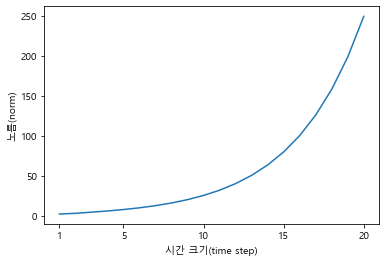

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)          # 기울기 폭발 (스칼라일 경우 Wh가 1보다 큰경 우)  --> NaN
# Wh = np.random.randn(H, H) * 0.5  # 기울기 소실 (스칼라일 경우 Wh가 1보다 작은 경우) --> 0
print('Wh:\n',Wh)


# Norm은 벡터의 길이 혹은 크기를 측정하는 방법(함수)이다
# L1 norm : 벡터의 각 요소의 절대값을 모두 합한 값
# L2 norm : 각 요소의 제곱을 모두 합하여 제곱근을 취한 값
# http://taewan.kim/post/norm/
norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()


### 기울기 폭발 대책 : 기울기 클리핑(gradient cliping) 함수 구현
https://wikidocs.net/61375

In [10]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
print('dW1:\n',dW1)
print('dW2:\n',dW2)
grads = [dW1, dW2]
max_norm = 5.0  # threshold, 한계값

## nn_layers.py 에 추가한다
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:  # L2 norm 구하기 , 제곱의 합의 제곱근
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1: # total_norm 이 한계값(max_norm) 보다 클경우
        for grad in grads:
            grad *= rate

print('(dW1) before:', dW1.flatten())
clip_grads(grads, max_norm)
print('(dw1) after:', dW1.flatten())  # 값이 약간 줄어듦

dW1:
 [[6.49144048 2.78487283 6.76254902]
 [5.90862817 0.23981882 5.58854088]
 [2.59252447 4.15101197 2.83525082]]
dW2:
 [[6.93137918 4.40453718 1.56867738]
 [5.44649018 7.80314765 3.06363532]
 [2.21957884 3.87971258 9.3638365 ]]
(dW1) before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
(dw1) after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


#### 기울기 소실 방지 : Gated RNN 인 LSTM(Long Short Term Memory)이나  GRU(Gated Recurrent Units ) 사용
#### LSTM  : RNN에 기억 셀 𝐜<sub>𝐭</sub> 과 , f , g, i, o 게이트 추가

In [38]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))


class LSTM:
    def __init__(self,Wx,Wh,b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),np.zeros_like(b)]
        self.cache = None
        
    def forward(self,x,h_prev,c_prev):
        Wx, Wh, b = self.params # Wx : (D,4*H), Wh : (H,4*H)
        N,H = h_prev.shape
        
        A = np.dot(x,Wx) + np.dot(h_prev,Wh) + b # (N,4*H)
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f*c_prev + g*i
        h_next = o*np.tanh(c_next)
        
        self.cache = (x,h_prev, c_prev,c_next, f,g,i,o)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, c_next, f,g,i,o = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds= dc_next + (o*dh_next)*(1- tanh_c_next**2) # 중요한 부분
        
        dc_prev = ds +f
        
        df = ds * c_prev
        dg = ds * i
        di= ds * g
        do = dh_next * tanh_c_next
        
        # sigmoid 미분 x*(1-x)
        df *= f * (1-f)
        di *= i * (1-i)
        do *= o * (1-o)
        
        # tanh 미분 (1- y**2)
        dg *= (1-g**2)
        
        dA = np.hstack((df,dg,di,do))
        
        dWh = np.dot(h_prev.T, dA)
        dh_prev = np.dot(dA, Wh.T)
        
        dWx = np.dot(x.T, dA)
        dx = np.dot(dA, Wx.T)
        
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev, dc_prev

## Time LSTM 구현
- Time RNN과 유사

In [40]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),np.zeros_like(b)]
        self.layers = None         #   RNN층을 리스트로 저장
        
        self.h, self.c, self.dh = None, None, None
        
        self.stateful = stateful   # RNN 계층 사이에서 은닉 상태를 인계한다
    
    def set_state(self, h, c = None):
        self.h, self.c = h, c 

    def reset_state(self):
        self.h, self.c = None, None
        
    # 순전파
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # N : batch size T : sequence length D : input size
        H = Wh.shape[0] # D  : input size  H : hidden size
        
        self.layers = []
        hs = np.empty((N,T,H),dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H),dtype='f')
            
        if not self.stateful or self.c is None:
            self.c = np.zeros((N,H),dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:,t,:],self.h, self.c)
            
            hs[:,t,:] = self.h
            self.layers.append(layer)
            
        return hs
        
    def backward(self,dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape 
        D = Wx.shape[0] # Wx : (D,4*H)
        
        dxs = np.empty((N,T,D),dtype = 'f')
        dh, dc = 0, 0
        grads = [0,0,0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx,dh,DC = layer.backward(dhs[:,t,:] + dh,dc)  # RNN dx, dh_prev 호출
            dxs[:,t,:] = dx
            
            for i, grad in enumerate(layer.grads):  # 기울기를 합산
                grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

In [35]:
import pickle

class Rnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H =  vocab_size, wordvec_size, hidden_size # 10000, 100, 100
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype('f')
        
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f') # Xavier(GLorot) 초기화
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b,stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self,xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
            
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
            
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name,'rb') as f:
            self.params = pickle.load(f) 


In [26]:
from nn_layers import sigmoid, SGD, TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss, RnnlmTrainer
from dataset import ptb
import numpy as np

In [36]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 20.0
# max_epoch = 4  #  약 30분 소요 , PPL : 약 136.07
max_epoch = 1
max_grad = 0.25  #  기울기 클리핑을 위한 threshold 값

# 학습 데이터 읽기 : 전체 데이터 사용
# https://raw.githubusercontent.com/tomsercu/Lstm/master/data/ptb.train.txt
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test,_,_ = ptb.load_data('test')
vocab_size = len(word_to_id)
print(vocab_size, len(corpus))

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력（정답 레이블）

10000 929589


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 퍼플렉서티 9999.84
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 퍼플렉서티 3160.31
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 퍼플렉서티 1436.62
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 퍼플렉서티 1025.10
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 퍼플렉서티 917.06
| 에폭 1 |  반복 101 / 9295 | 시간 7[s] | 퍼플렉서티 684.99
| 에폭 1 |  반복 121 / 9295 | 시간 8[s] | 퍼플렉서티 827.19
| 에폭 1 |  반복 141 / 9295 | 시간 10[s] | 퍼플렉서티 738.27
| 에폭 1 |  반복 161 / 9295 | 시간 11[s] | 퍼플렉서티 742.27
| 에폭 1 |  반복 181 / 9295 | 시간 13[s] | 퍼플렉서티 591.12
| 에폭 1 |  반복 201 / 9295 | 시간 14[s] | 퍼플렉서티 547.50
| 에폭 1 |  반복 221 / 9295 | 시간 15[s] | 퍼플렉서티 548.06
| 에폭 1 |  반복 241 / 9295 | 시간 17[s] | 퍼플렉서티 606.98
| 에폭 1 |  반복 261 / 9295 | 시간 18[s] | 퍼플렉서티 577.98
| 에폭 1 |  반복 281 / 9295 | 시간 20[s] | 퍼플렉서티 500.59
| 에폭 1 |  반복 301 / 9295 | 시간 21[s] | 퍼플렉서티 407.46
| 에폭 1 |  반복 321 / 9295 | 시간 22[s] | 퍼플렉서티 490.24
| 에폭 1 |  반복 341 / 9295 | 시간 24[s] | 퍼플렉서티 396.16
| 에폭 1 |  반복 361 / 9295 | 시간 25[s] | 퍼플렉서티 440.24
| 에폭 1 |  반복 381 / 9295 | 시간 26[s] | 퍼플렉서티 445.25
| 에폭 1 | 

| 에폭 1 |  반복 3221 / 9295 | 시간 220[s] | 퍼플렉서티 254.46
| 에폭 1 |  반복 3241 / 9295 | 시간 221[s] | 퍼플렉서티 262.62
| 에폭 1 |  반복 3261 / 9295 | 시간 222[s] | 퍼플렉서티 258.58
| 에폭 1 |  반복 3281 / 9295 | 시간 224[s] | 퍼플렉서티 243.13
| 에폭 1 |  반복 3301 / 9295 | 시간 225[s] | 퍼플렉서티 237.02
| 에폭 1 |  반복 3321 / 9295 | 시간 226[s] | 퍼플렉서티 227.12
| 에폭 1 |  반복 3341 / 9295 | 시간 228[s] | 퍼플렉서티 199.57
| 에폭 1 |  반복 3361 / 9295 | 시간 229[s] | 퍼플렉서티 193.72
| 에폭 1 |  반복 3381 / 9295 | 시간 230[s] | 퍼플렉서티 217.84
| 에폭 1 |  반복 3401 / 9295 | 시간 232[s] | 퍼플렉서티 233.82
| 에폭 1 |  반복 3421 / 9295 | 시간 233[s] | 퍼플렉서티 226.15
| 에폭 1 |  반복 3441 / 9295 | 시간 235[s] | 퍼플렉서티 293.46
| 에폭 1 |  반복 3461 / 9295 | 시간 236[s] | 퍼플렉서티 276.18
| 에폭 1 |  반복 3481 / 9295 | 시간 237[s] | 퍼플렉서티 272.19
| 에폭 1 |  반복 3501 / 9295 | 시간 239[s] | 퍼플렉서티 239.48
| 에폭 1 |  반복 3521 / 9295 | 시간 240[s] | 퍼플렉서티 300.46
| 에폭 1 |  반복 3541 / 9295 | 시간 241[s] | 퍼플렉서티 289.23
| 에폭 1 |  반복 3561 / 9295 | 시간 243[s] | 퍼플렉서티 287.70
| 에폭 1 |  반복 3581 / 9295 | 시간 244[s] | 퍼플렉서티 222.97
| 에폭 1 |  반복

| 에폭 1 |  반복 6381 / 9295 | 시간 441[s] | 퍼플렉서티 210.85
| 에폭 1 |  반복 6401 / 9295 | 시간 442[s] | 퍼플렉서티 237.78
| 에폭 1 |  반복 6421 / 9295 | 시간 444[s] | 퍼플렉서티 217.17
| 에폭 1 |  반복 6441 / 9295 | 시간 445[s] | 퍼플렉서티 198.46
| 에폭 1 |  반복 6461 / 9295 | 시간 447[s] | 퍼플렉서티 205.83
| 에폭 1 |  반복 6481 / 9295 | 시간 449[s] | 퍼플렉서티 180.83
| 에폭 1 |  반복 6501 / 9295 | 시간 450[s] | 퍼플렉서티 198.64
| 에폭 1 |  반복 6521 / 9295 | 시간 452[s] | 퍼플렉서티 266.21
| 에폭 1 |  반복 6541 / 9295 | 시간 453[s] | 퍼플렉서티 276.93
| 에폭 1 |  반복 6561 / 9295 | 시간 454[s] | 퍼플렉서티 224.88
| 에폭 1 |  반복 6581 / 9295 | 시간 456[s] | 퍼플렉서티 181.10
| 에폭 1 |  반복 6601 / 9295 | 시간 458[s] | 퍼플렉서티 200.40
| 에폭 1 |  반복 6621 / 9295 | 시간 459[s] | 퍼플렉서티 238.42
| 에폭 1 |  반복 6641 / 9295 | 시간 461[s] | 퍼플렉서티 215.94
| 에폭 1 |  반복 6661 / 9295 | 시간 462[s] | 퍼플렉서티 212.26
| 에폭 1 |  반복 6681 / 9295 | 시간 464[s] | 퍼플렉서티 254.34
| 에폭 1 |  반복 6701 / 9295 | 시간 465[s] | 퍼플렉서티 279.28
| 에폭 1 |  반복 6721 / 9295 | 시간 467[s] | 퍼플렉서티 220.69
| 에폭 1 |  반복 6741 / 9295 | 시간 468[s] | 퍼플렉서티 198.92
| 에폭 1 |  반복

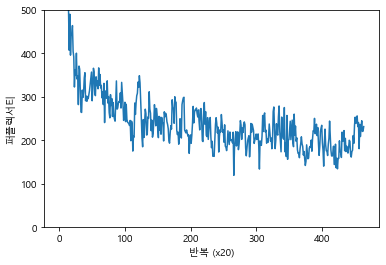

In [41]:
# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)


# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0,500))

In [42]:
import sys
def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl

In [43]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)  # test 데이터로 평가
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  217.1683731569433


## 개선된 RNNLM

- Lstm을 2층 구현
- 가중치를 공유( embedded와 affine계층)
- dropout

In [44]:
class BetterRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H =  vocab_size, wordvec_size, hidden_size # 10000, 100, 100
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype('f')
        
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f') # Xavier(GLorot) 초기화
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b,stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self,xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
            
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
            
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name,'rb') as f:
            self.params = pickle.load(f) 

In [45]:
# TimeDropout 클래스
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
# dropout 된 입력 데이터는 0이 된다
# dropout 되지 않은 입력 데이터는  1/(1 - rate)을 곱하여 scale up 시킨다 (droput rate:0~1)

# nn_layers.py에 추가

class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params,self.grads = [],[]
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True   # 학습시에만 True로 설정하여 dropout 적용, 예측시에는 사용하지 않음
        
    def forward(self,xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio            
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs
            
    def backward(self, dout):
        return dout * self.mask  


In [46]:
dropout_ratio = 0.5
dr = TimeDropout(dropout_ratio)

xs = np.arange(1,10).reshape(3,3)
print('xs:\n',xs)

# dr.train_flg = True
drop_xs = dr.forward(xs)
print('drop_xs:\n',drop_xs)

print('-'*30)
flg = np.random.rand(*xs.shape) > dropout_ratio    
print('flg:\n',flg)
print(xs*flg)

xs:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
drop_xs:
 [[ 0.  4.  6.]
 [ 8.  0. 12.]
 [14.  0. 18.]]
------------------------------
flg:
 [[ True  True False]
 [ True False  True]
 [False  True  True]]
[[1 2 0]
 [4 0 6]
 [0 8 9]]


In [47]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 20.0
# max_epoch = 40  #  약 2일 소요 , PPL : 약 75.76
max_epoch = 1
max_grad = 0.25  #  기울기 클리핑을 위한 threshold 값
dropout = 0.5

# 학습 데이터 읽기 : 전체 데이터 사용
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val,_,_ = ptb.load_data('val')
corpus_test,_,_ = ptb.load_data('test')

vocab_size = len(word_to_id)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력（정답 레이블）

# 모델 생성
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)

Done
| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 퍼플렉서티 9996.62
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 퍼플렉서티 3220.30
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 퍼플렉서티 1429.64
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 퍼플렉서티 1046.15
| 에폭 1 |  반복 81 / 9295 | 시간 6[s] | 퍼플렉서티 898.89
| 에폭 1 |  반복 101 / 9295 | 시간 7[s] | 퍼플렉서티 673.11
| 에폭 1 |  반복 121 / 9295 | 시간 9[s] | 퍼플렉서티 833.76
| 에폭 1 |  반복 141 / 9295 | 시간 11[s] | 퍼플렉서티 732.22
| 에폭 1 |  반복 161 / 9295 | 시간 12[s] | 퍼플렉서티 745.81
| 에폭 1 |  반복 181 / 9295 | 시간 13[s] | 퍼플렉서티 585.83
| 에폭 1 |  반복 201 / 9295 | 시간 15[s] | 퍼플렉서티 548.04
| 에폭 1 |  반복 221 / 9295 | 시간 16[s] | 퍼플렉서티 544.92
| 에폭 1 |  반복 241 / 9295 | 시간 18[s] | 퍼플렉서티 600.94
| 에폭 1 |  반복 261 / 9295 | 시간 19[s] | 퍼플렉서티 578.72
| 에폭 1 |  반복 281 / 9295 | 시간 20[s] | 퍼플렉서티 509.12
| 에폭 1 |  반복 301 / 9295 | 시간 22[s] | 퍼플렉서티 411.38
| 에폭 1 |  반복 321 / 9295 | 시간 23[s] | 퍼플렉서티 492.05
| 에폭 1 |  반복 341 / 9295 | 시간 25[s] | 퍼플렉서티 398.66
| 에폭 1 |  반복 361 / 9295 | 시간 27[s] | 퍼플렉서티 447.82
| 에폭 1 |  반복 381 / 9295 | 시간 28[s] | 퍼플렉서티 451.73
| 에폭

| 에폭 1 |  반복 3201 / 9295 | 시간 228[s] | 퍼플렉서티 259.58
| 에폭 1 |  반복 3221 / 9295 | 시간 230[s] | 퍼플렉서티 252.12
| 에폭 1 |  반복 3241 / 9295 | 시간 231[s] | 퍼플렉서티 248.66
| 에폭 1 |  반복 3261 / 9295 | 시간 232[s] | 퍼플렉서티 254.11
| 에폭 1 |  반복 3281 / 9295 | 시간 234[s] | 퍼플렉서티 248.11
| 에폭 1 |  반복 3301 / 9295 | 시간 235[s] | 퍼플렉서티 234.32
| 에폭 1 |  반복 3321 / 9295 | 시간 237[s] | 퍼플렉서티 228.40
| 에폭 1 |  반복 3341 / 9295 | 시간 238[s] | 퍼플렉서티 202.76
| 에폭 1 |  반복 3361 / 9295 | 시간 239[s] | 퍼플렉서티 187.27
| 에폭 1 |  반복 3381 / 9295 | 시간 241[s] | 퍼플렉서티 213.82
| 에폭 1 |  반복 3401 / 9295 | 시간 242[s] | 퍼플렉서티 239.32
| 에폭 1 |  반복 3421 / 9295 | 시간 243[s] | 퍼플렉서티 229.39
| 에폭 1 |  반복 3441 / 9295 | 시간 245[s] | 퍼플렉서티 288.93
| 에폭 1 |  반복 3461 / 9295 | 시간 246[s] | 퍼플렉서티 273.71
| 에폭 1 |  반복 3481 / 9295 | 시간 248[s] | 퍼플렉서티 271.94
| 에폭 1 |  반복 3501 / 9295 | 시간 249[s] | 퍼플렉서티 238.32
| 에폭 1 |  반복 3521 / 9295 | 시간 250[s] | 퍼플렉서티 300.48
| 에폭 1 |  반복 3541 / 9295 | 시간 252[s] | 퍼플렉서티 293.25
| 에폭 1 |  반복 3561 / 9295 | 시간 253[s] | 퍼플렉서티 284.87
| 에폭 1 |  반복

| 에폭 1 |  반복 6361 / 9295 | 시간 449[s] | 퍼플렉서티 197.76
| 에폭 1 |  반복 6381 / 9295 | 시간 450[s] | 퍼플렉서티 215.47
| 에폭 1 |  반복 6401 / 9295 | 시간 451[s] | 퍼플렉서티 240.27
| 에폭 1 |  반복 6421 / 9295 | 시간 453[s] | 퍼플렉서티 214.46
| 에폭 1 |  반복 6441 / 9295 | 시간 454[s] | 퍼플렉서티 198.77
| 에폭 1 |  반복 6461 / 9295 | 시간 455[s] | 퍼플렉서티 205.28
| 에폭 1 |  반복 6481 / 9295 | 시간 457[s] | 퍼플렉서티 188.54
| 에폭 1 |  반복 6501 / 9295 | 시간 458[s] | 퍼플렉서티 201.83
| 에폭 1 |  반복 6521 / 9295 | 시간 460[s] | 퍼플렉서티 274.32
| 에폭 1 |  반복 6541 / 9295 | 시간 461[s] | 퍼플렉서티 276.10
| 에폭 1 |  반복 6561 / 9295 | 시간 463[s] | 퍼플렉서티 231.23
| 에폭 1 |  반복 6581 / 9295 | 시간 464[s] | 퍼플렉서티 180.05
| 에폭 1 |  반복 6601 / 9295 | 시간 466[s] | 퍼플렉서티 203.26
| 에폭 1 |  반복 6621 / 9295 | 시간 467[s] | 퍼플렉서티 237.80
| 에폭 1 |  반복 6641 / 9295 | 시간 469[s] | 퍼플렉서티 209.10
| 에폭 1 |  반복 6661 / 9295 | 시간 470[s] | 퍼플렉서티 212.11
| 에폭 1 |  반복 6681 / 9295 | 시간 472[s] | 퍼플렉서티 255.93
| 에폭 1 |  반복 6701 / 9295 | 시간 473[s] | 퍼플렉서티 260.97
| 에폭 1 |  반복 6721 / 9295 | 시간 474[s] | 퍼플렉서티 223.92
| 에폭 1 |  반복

In [48]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  213.3307854523158
